# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from unidecode import unidecode

from gensim.models import Word2Vec

from sklearn.dummy import DummyClassifier

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [4]:
data.iloc[18, 1]


'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [5]:
# YOUR CODE HERE
data['verse'] = data['verse'].apply(unidecode)
data.iloc[18, 1]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [6]:
# YOUR CODE HERE
print('Before removing duplicates', data.shape)
data.drop_duplicates()
print('After removing duplicates', data.shape)

Before removing duplicates (3975, 2)
After removing duplicates (3975, 2)


In [7]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [8]:
data.artist.value_counts()

Drake         1690
Ed Sheeran    1405
Kanye West     880
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [9]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [10]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [11]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,to
5,to,me,and
6,a,to,a
7,it,my,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [12]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [13]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [14]:
# YOUR CODE HERE
data['seq'] = data['verse'].apply(tf.keras.preprocessing.text.text_to_word_sequence)
data

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]"
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

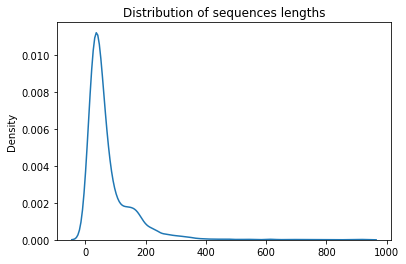

In [15]:
# YOUR CODE HERE
def plot_dist(X):
    len_ = [len(_) for _ in X]
    sns.kdeplot(len_)
    plt.title('Distribution of sequences lengths')
    
plot_dist(data.seq)

# It is more than reasonable to keep only first 300 words in every sentence

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

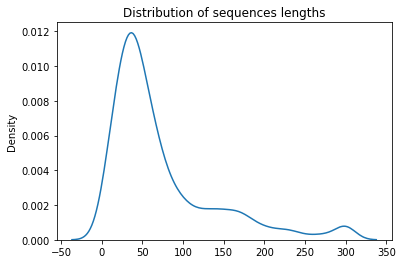

In [16]:
# YOUR CODE HERE
data.seq = data.seq.apply(lambda x: x[:300])
plot_dist(data.seq)

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [17]:
# YOUR CODE HERE
data["embed"] = ''
w2v = Word2Vec(sentences=data.seq, vector_size=100, min_count = 1, epochs=50)
for index, row in data.iterrows():
    vector_list = []
    for word in row['seq']:
        vector_list.append(w2v.wv[word])
    row['embed'] = vector_list
data

,artist,verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[-1.1745986, -1.1311908, 1.6296526, 2.8897192..."
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[0.53016883, -1.4851011, -2.6239064, 1.900955..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[0.036840435, 0.91150767, 0.73487157, -0.2002..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[-3.0133429, 1.5717919, -1.984135, -0.6896245..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[0.53016883, -1.4851011, -2.6239064, 1.900955..."
...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...","[[-0.18795946, 0.7232061, -0.24068533, -0.4376..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...","[[-1.295618, -0.15083875, 1.0762933, 2.0258372..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]","[[0.036840435, 0.91150767, 0.73487157, -0.2002..."
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...","[[-0.57347256, 1.9989786, 0.9416816, -0.043875..."


In [18]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [19]:
# YOUR CODE HERE
X_ = data.embed.to_numpy()

X = np.empty((data.shape[0], 300, 100))

for i, item in enumerate(X_[0]):
    X[i] = item

X

array([[[-1.17459857, -1.13119078,  1.62965262, ...,  0.71604693,
         -2.79161143, -2.11608529],
        [-1.17459857, -1.13119078,  1.62965262, ...,  0.71604693,
         -2.79161143, -2.11608529],
        [-1.17459857, -1.13119078,  1.62965262, ...,  0.71604693,
         -2.79161143, -2.11608529],
        ...,
        [-1.17459857, -1.13119078,  1.62965262, ...,  0.71604693,
         -2.79161143, -2.11608529],
        [-1.17459857, -1.13119078,  1.62965262, ...,  0.71604693,
         -2.79161143, -2.11608529],
        [-1.17459857, -1.13119078,  1.62965262, ...,  0.71604693,
         -2.79161143, -2.11608529]],

       [[-2.80597472, -1.76430619,  0.83992797, ..., -0.52036244,
          0.09457886,  2.29822564],
        [-2.80597472, -1.76430619,  0.83992797, ..., -0.52036244,
          0.09457886,  2.29822564],
        [-2.80597472, -1.76430619,  0.83992797, ..., -0.52036244,
          0.09457886,  2.29822564],
        ...,
        [-2.80597472, -1.76430619,  0.83992797, ..., -

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [21]:
# YOUR CODE HERE
d = {'Drake':0, 'Ed Sheeran':1, 'Kanye West':2}
y = tf.keras.utils.to_categorical(data.artist.apply(lambda x: d.get(x)), num_classes = 3)
y.shape

(3975, 3)

👉 We train/test split the dataset below for you

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [24]:
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

! rm data_lyrics_solution.pickle

--2021-06-29 17:39:04--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.80.73
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.80.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio 100%[===================>] 693.81M  10.7MB/s    in 71s     

2021-06-29 17:40:15 (9.75 MB/s) - ‘data_lyrics_solution.pickle’ saved [727513032/727513032]



❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [25]:
# YOUR CODE HERE
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

score_baseline = dummy_clf.score(X_train, y_train)
score_baseline

0.17986798679867988

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [26]:
# YOUR CODE HERE
# opt = tf.keras.optimizers.RMSprop(learning_rate=1)

model = Sequential()

model.add(Masking(mask_value=0, input_shape=(300, 100)))

model.add(LSTM(units=20, activation = 'tanh'))

model.add(Dense(units=100, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(units=3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics = 'accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                9680      
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 12,083
Trainable params: 12,083
Non-trainable params: 0
_________________________________________________________________


❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [27]:
# YOUR CODE HERE
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                   batch_size = 16,
                   epochs = 1000,
                   callbacks=es,
                   validation_split=0.3)

Epoch 1/1000
106/106 [==============================] - 15s 121ms/step - loss: 1.0794 - accuracy: 0.4247 - val_loss: 1.0384 - val_accuracy: 0.4588
Epoch 2/1000
106/106 [==============================] - 11s 108ms/step - loss: 1.0158 - accuracy: 0.4881 - val_loss: 0.9931 - val_accuracy: 0.4904
Epoch 3/1000
106/106 [==============================] - 11s 106ms/step - loss: 0.9332 - accuracy: 0.5576 - val_loss: 0.9454 - val_accuracy: 0.5330
Epoch 4/1000
106/106 [==============================] - 11s 105ms/step - loss: 0.8578 - accuracy: 0.6103 - val_loss: 0.9068 - val_accuracy: 0.5549
Epoch 5/1000
106/106 [==============================] - 11s 104ms/step - loss: 0.7365 - accuracy: 0.7049 - val_loss: 0.8765 - val_accuracy: 0.5907
Epoch 6/1000
106/106 [==============================] - 11s 105ms/step - loss: 0.6642 - accuracy: 0.7306 - val_loss: 0.8816 - val_accuracy: 0.6085
Epoch 7/1000
106/106 [==============================] - 11s 104ms/step - loss: 0.5974 - accuracy: 0.7610 - val_loss: 0

❓ **Plot the training and validation losses through training**

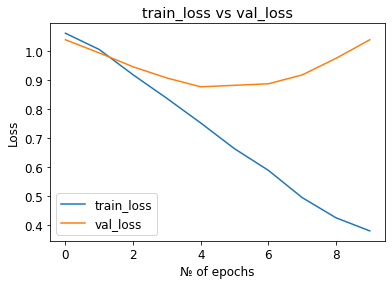

In [28]:
# Plot below your train/val loss history
# YOUR CODE HERE
plt.rc('font', size=12)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.title("train_loss vs val_loss")
plt.xlabel("№ of epochs")
plt.ylabel("Loss")

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [29]:
# YOUR CODE HERE
'Model is overfitting despite optimization of the learning rate and the dropout layer. Have no time to adjust it properly.'
score_test = model.evaluate(X_test, y_test)[1]
score_test

19/19 [==============================] - 1s 32ms/step - loss: 0.8833 - accuracy: 0.5898


0.5897858142852783

🧪 **Send your results below**

In [30]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()